In [1]:
!pip install osmnx
!pip install mercantile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 3.8 MB/s eta 0:00:00


In [12]:
# import geopandas as gpd
import osmnx as ox
import mercantile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import pandas as pd
import requests
import shapely
from shapely.geometry import Point, LineString, Polygon
import pyproj
import os
from google.colab import drive
import pickle
import json
import time

# Mount to Gdrive

In [3]:
# connect to drive
drive.mount('/gdrive')

path = '/gdrive/MyDrive/berlin_bike_CV/'
folder = 'metadata'
mapillary_folder = 'mapillary'

name = 'DSR'

Mounted at /gdrive


# Load Data

In [14]:
# TODO load original graph (to find geometry information), list of edges per tile, and mapillary data per tile

# load original graph
graph_name = '_graph_origin.pkl'
graph_path = os.path.join(path, folder, name + graph_name)
with open(graph_path, 'rb') as pickle_file:
    G = pickle.load(pickle_file)

# load edges per tile
file_name = '_tiles_edges.pkl'
file_path = os.path.join(path, folder, name + file_name)
with open(file_path, 'rb') as pickle_file:
  tiles_data = pickle.load(pickle_file)

# # load mapillary data per tile
# file_name = 'tiles_berlin_mapillary_data.pkl'
# file_path = os.path.join(path, folder, file_name)
# with open(file_path, 'rb') as pickle_file:
#   mapillary_data = pickle.load(pickle_file)

In [ ]:
# defining coordinate to metre and metre to coordinate transformers
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 geographic coordinate system
target_crs = pyproj.CRS(proj= 'utm', zone=33)  # Spherical Mercator projection in meters

transformer_coord_2_metre = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

transformer_metre_2_coord = pyproj.Transformer.from_crs(target_crs, source_crs, always_xy=True)

In [ ]:
# defining constant values for offset and width of each polygon (bounding box)
POLYGONOFFSET = 5
POLYGONWIDTH = 10

In [ ]:
# defining offset
# TODO: take into account when street is shorter than the offset!

import math

def find_point_on_line(point1, point2, distance=POLYGONOFFSET):

    direction_vector = (point2[0] - point1[0], point2[1] - point1[1])

    direction_length = math.sqrt(direction_vector[0]**2 + direction_vector[1]**2)

    normalized_direction = (direction_vector[0] / direction_length, direction_vector[1] / direction_length)

    point_on_line = (point1[0] + normalized_direction[0] * distance, point1[1] + normalized_direction[1] * distance)

    return point_on_line

In [ ]:
# define polygon for street
def street_polygon(u, v, k):

  if 'geometry' in G.edges[(u, v, k)]:
    geometry = G.edges[(u, v, k)]['geometry']

  else:
    geometry = LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])

  # TODO: define a function for the list transformation
  list_geom = list(geometry.coords)
  list_lon = [coord[0] for coord in list_geom]
  list_lat = [coord[1] for coord in list_geom]
  list_x, list_y = transformer_coord_2_metre.transform(list_lon, list_lat)

  list_geom = list(zip(list_x, list_y))
  list_geom[0] = find_point_on_line(list_geom[0], list_geom[1])
  list_geom[-1] = find_point_on_line(list_geom[-1], list_geom[-2])

  list_geom = LineString(list_geom)
  transformed_polygon = list_geom.buffer(distance=POLYGONWIDTH, cap_style=3)

  list_geom = list(transformed_polygon.exterior.coords)
  list_x = [coord[0] for coord in list_geom]
  list_y = [coord[1] for coord in list_geom]

  list_lon, list_lat = transformer_metre_2_coord.transform(list_x, list_y)

  polygon = Polygon(list(zip(list_lon, list_lat)))

  # print(geometry)
  # print(polygon)

  return polygon

In [ ]:
# Download script goes in here

In [ ]:
# point is within street polygon
# TODO: check column name of point, x/y or better 0/1 for feature['geometry']['coordinates']?
def is_in_street_polygon(point, polygon):

    is_contained = polygon.contains(Point(point[0], point[1]))

    return is_contained

In [ ]:
# loop through list of tiles to get tile z/x/y to plug in to Mapillary endpoints and make request
for tile_quadkey, edges in tiles_data.items():
    # tile = mercantile.quadkey_to_tile(tile_quadkey)
    # tile_url = 'https://tiles.mapillary.com/maps/vtp/{}/2/{}/{}/{}?access_token={}'.format(tile_coverage,tile.z,tile.x,tile.y,access_token)
    # response = requests.get(tile_url)
    # data = vt_bytes_to_geojson(response.content, tile.x, tile.y, tile.z,layer=tile_layer)

    file_name = tile_quadkey + '.geojson'
    file_path = os.path.join(path, folder, mapillary_folder, file_name)
    with open(file_path, 'r') as f:
        data = json.load(f)

    for (u, v, k) in edges:
        polygon = street_polygon(u, v, k)
        image_list = []

        for feature in data['features']:

            # get lng,lat of each feature
            lng = feature['geometry']['coordinates'][0]
            lat = feature['geometry']['coordinates'][1]

            if is_in_street_polygon((lng, lat), polygon):
                image_id = feature['properties']['id']
                image_prop = {image_id: {'coordinates': [lng, lat]}}
                image_list.append(image_prop)

                if len(image_list) >= 3:
                    break

        tiles_data[tile_quadkey][(u, v, k)] = image_list



In [ ]:
# TODO: save dict of tiles with image data
file_name = '_tiles_edges_with_images.pkl'
file_path = os.path.join(path, folder, name + file_name)
with open(file_path, 'wb') as pickle_file:
    pickle.dump(tiles_data, pickle_file)

print('Done')

Done


In [1]:
# file_name = '_tiles_edges_with_images.pkl'
# file_path = os.path.join(path, folder, name + file_name)

NameError: ignored

In [6]:
# with open(file_path, 'rb') as pickle_file:
#   tiles_reconstructed = pickle.load(pickle_file)

In [ ]:
# print(len(tiles_reconstructed))
# list_x = []
# list_y = []
# for key, value in tiles_reconstructed.items():

#     for edge, images in value.items():
#         if len(images) == 0:
#             (u, v, k) = edge
#             list_x.append(G.nodes[u]['x'])
#             list_y.append(G.nodes[u]['y'])
#             list_x.append(G.nodes[v]['x'])
#             list_y.append(G.nodes[v]['y'])

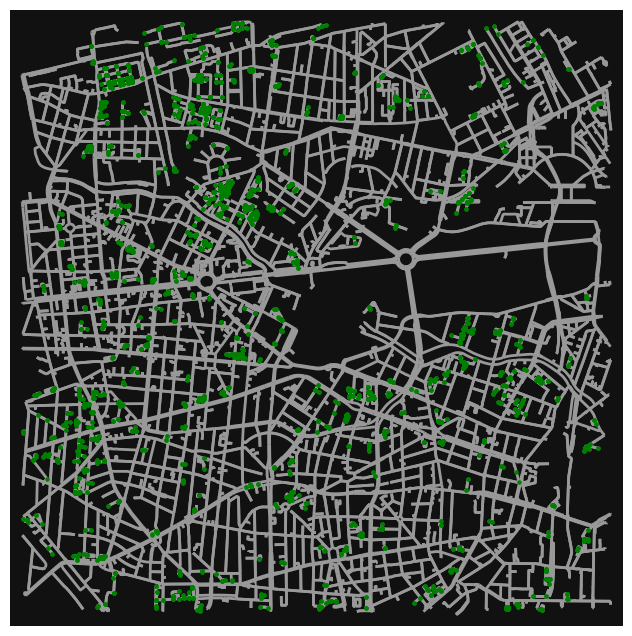

In [21]:
# fig, ax = ox.plot_graph(G, edge_linewidth=2, node_size=0, show=False, close=False)

# ax.scatter(
#   list_x,
#   list_y,
#   c="green",
#   s=5,
#   marker="o",
#   )

In [ ]:
# print(tiles_data[tile_quadkey])

{(26662368, 26682529, 0): [{153159273439002: {'coordinates': [13.305875658988953, 52.524684756516535]}}, {502507304521072: {'coordinates': [13.30618679523468, 52.52470433941369]}}, {467181627704592: {'coordinates': [13.30617070198059, 52.524714130859024]}}], (26662368, 9007281304, 0): [{502507304521072: {'coordinates': [13.30618679523468, 52.52470433941369]}}, {318708449843639: {'coordinates': [13.307066559791565, 52.52469781178226]}}, {467181627704592: {'coordinates': [13.30617070198059, 52.524714130859024]}}], (26662368, 26784424, 0): [{972579900201716: {'coordinates': [13.306245803833008, 52.52554639573262]}}, {1889523521229025: {'coordinates': [13.306240439414978, 52.52554965948539]}}, {558267818529974: {'coordinates': [13.306245803833008, 52.525614934489994]}}], (26662377, 1516808200, 0): [{238606904688587: {'coordinates': [13.303397297859192, 52.524691284149895]}}, {300931308293805: {'coordinates': [13.303499221801758, 52.52468802033334]}}, {149925400480363: {'coordinates': [13.3